In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from datetime import datetime

# metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score

# models
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

# Reading Data from File

In [2]:
df = pd.read_csv("wind/wind_speed_simple.csv", index_col=0)
df["date"] = pd.to_datetime(df["date"])
df

,date,lon,lat,windvelo
0,2007-01-01,116.5,21.50,11.752896
1,2007-01-01,116.5,21.25,11.805607
2,2007-01-01,116.5,21.00,11.851288
3,2007-01-01,116.5,20.75,11.921542
4,2007-01-01,116.5,20.50,12.004713
...,...,...,...,...
536755,2020-12-01,127.5,5.00,1.671269
536756,2020-12-01,127.5,4.75,1.614607
536757,2020-12-01,127.5,4.50,1.562249
536758,2020-12-01,127.5,4.25,1.502779


In [3]:
df.describe()

,lon,lat,windvelo
count,536760.000000,536760.00000,536760.000000
mean,122.000000,12.75000,4.319529
std,3.246796,5.12348,2.926312
min,116.500000,4.00000,0.004706
25%,119.250000,8.25000,1.974124
50%,122.000000,12.75000,3.777370
75%,124.750000,17.25000,6.105839
max,127.500000,21.50000,16.687559


# EDA and Feature Engineering

In [4]:
def get_stationarity_p_value(df):
    stationarity_test = adfuller(df, autolag="AIC", maxlag=20)
    return stationarity_test[1]

In [5]:
def convert_to_dict(lst):
    res_dct = {i+1: lst[i] for i in range(0, len(lst))}
    return res_dct

In [54]:
def get_acf_lag(df, nlags=12):
    acf = sm.tsa.acf(df, nlags=nlags, alpha=0.05, qstat=True, fft=False)

    confidence_intervals = acf[1]
    p_values = convert_to_dict(acf[3])

    lag = min(p_values, key=p_values.get)
    p_value = p_values[lag]
    acf = np.mean(confidence_intervals[lag-1])

    return { "lag": int(lag), "acf": acf, "p_value": p_value }

In [8]:
latitudes = df["lat"].unique().tolist()
assert len(latitudes) == 71
longitudes = df["lon"].unique().tolist()
assert len(longitudes) == 45

In [10]:
grid_dict = {}
feature = "windvelo"
expected_obs_count = 12 * 14 # 14 years of monthly observations

In [11]:
for lat in latitudes:
    for lon in longitudes:
        grid_df = df[(df.lon == lon) & (df.lat == lat)][["date", feature]].set_index("date", drop=True)
        assert len(grid_df) == expected_obs_count
        grid_dict[(lat, lon)] = {}
        grid_dict[(lat, lon)]["orig"] = grid_df
        grid_dict[(lat, lon)]["diff"] = grid_df.diff().dropna()
assert len(grid_dict) == 3195

In [55]:
per_grid_columns = [
    "lat", "lon",
    "diff_stationarity_pval", "diff_acf_lag", "diff_acf", "diff_acf_pval",
    "orig_stationarity_pval", "orig_acf_lag", "orig_acf", "orig_acf_pval", 
    ]
per_grid_df = pd.DataFrame(columns=per_grid_columns)
per_grid_df

for lat in latitudes:
    print("Getting values for latitude %.02f..." % lat)
    for lon in longitudes:
        diff_df = grid_dict[(lat, lon)]["diff"]
        orig_df = grid_dict[(lat, lon)]["orig"]
        diff_acf = get_acf_lag(diff_df)
        orig_acf = get_acf_lag(orig_df)
        row = { "lat": [lat],
                "lon": [lon],
                "diff_stationarity_pval": [ get_stationarity_p_value(diff_df) ],
                "diff_acf_lag": [ diff_acf["lag"] ],
                "diff_acf": [ diff_acf["acf"] ],
                "diff_acf_pval": [ diff_acf["p_value"] ],
                "orig_stationarity_pval": [ get_stationarity_p_value(orig_df) ],
                "orig_acf_lag": [ orig_acf["lag"] ],
                "orig_acf": [ orig_acf["acf"] ],
                "orig_acf_pval": [ orig_acf["p_value"] ],
              }
        data = pd.DataFrame.from_dict(row, orient="columns")
        per_grid_df = per_grid_df.append(data, ignore_index=True)
per_grid_df

Getting values for latitude 21.50...
Getting values for latitude 21.25...
Getting values for latitude 21.00...
Getting values for latitude 20.75...
Getting values for latitude 20.50...
Getting values for latitude 20.25...
Getting values for latitude 20.00...
Getting values for latitude 19.75...
Getting values for latitude 19.50...
Getting values for latitude 19.25...
Getting values for latitude 19.00...
Getting values for latitude 18.75...
Getting values for latitude 18.50...
Getting values for latitude 18.25...
Getting values for latitude 18.00...
Getting values for latitude 17.75...
Getting values for latitude 17.50...
Getting values for latitude 17.25...
Getting values for latitude 17.00...
Getting values for latitude 16.75...
Getting values for latitude 16.50...
Getting values for latitude 16.25...
Getting values for latitude 16.00...
Getting values for latitude 15.75...
Getting values for latitude 15.50...
Getting values for latitude 15.25...
Getting values for latitude 15.00...
G

,lat,lon,diff_stationarity_pval,diff_acf_lag,diff_acf,diff_acf_pval,orig_stationarity_pval,orig_acf_lag,orig_acf,orig_acf_pval
0,21.5,116.50,1.866722e-28,12,0.254409,5.256963e-17,0.066708,12,0.614973,1.051795e-106
1,21.5,116.75,1.477424e-28,12,0.251667,2.982327e-17,0.066572,12,0.615601,2.643029e-107
2,21.5,117.00,1.010146e-28,12,0.244515,5.474393e-17,0.066498,12,0.612801,3.251419e-106
3,21.5,117.25,9.233826e-29,12,0.239647,8.100042e-17,0.065972,12,0.611385,6.807207e-106
4,21.5,117.50,8.838024e-29,12,0.236478,1.010563e-16,0.066903,12,0.610915,6.806164e-106
...,...,...,...,...,...,...,...,...,...,...
3190,4.0,126.50,3.534167e-24,12,0.157231,9.029801e-32,0.002377,12,0.099996,4.599228e-36
3191,4.0,126.75,3.340451e-07,12,0.154478,2.710404e-28,0.001843,12,0.093877,2.270136e-32
3192,4.0,127.00,5.574461e-07,12,0.154295,3.535021e-27,0.002029,12,0.086419,1.982855e-31
3193,4.0,127.25,5.171985e-07,12,0.157109,2.678868e-26,0.001803,12,0.086204,9.098663e-31


In [67]:
# Since strings are not included in describe method output
per_grid_df["diff_acf_lag"] = pd.to_numeric(per_grid_df["diff_acf_lag"], errors="coerce")
per_grid_df["orig_acf_lag"] = pd.to_numeric(per_grid_df["orig_acf_lag"], errors="coerce")

In [68]:
per_grid_df.describe()

,lat,lon,diff_stationarity_pval,diff_acf_lag,diff_acf,diff_acf_pval,orig_stationarity_pval,orig_acf_lag,orig_acf,orig_acf_pval
count,3195.000000,3195.000000,3.195000e+03,3195.000000,3195.000000,3.195000e+03,3.195000e+03,3195.000000,3195.000000,3.195000e+03
mean,12.750000,122.000000,1.267982e-04,11.462598,0.145082,2.608589e-05,1.805226e-02,11.734898,0.387945,1.001178e-03
std,5.124277,3.247302,1.653360e-03,2.276605,0.190081,5.360446e-04,3.016311e-02,1.614010,0.184209,1.060991e-02
min,4.000000,116.500000,3.297296e-29,1.000000,-0.341561,5.162816e-48,6.648746e-22,1.000000,-0.199964,8.407932e-138
25%,8.250000,119.250000,6.684895e-26,12.000000,0.057260,1.137815e-15,1.001293e-03,12.000000,0.237310,3.213164e-84
50%,12.750000,122.000000,2.414554e-21,12.000000,0.121314,7.536374e-13,5.404149e-03,12.000000,0.400377,1.086073e-48
75%,17.250000,124.750000,2.158266e-09,12.000000,0.191529,3.363901e-09,2.105820e-02,12.000000,0.547794,5.897920e-29
max,21.500000,127.500000,6.748488e-02,12.000000,1.000000,1.958241e-02,3.324698e-01,12.000000,1.000000,2.276294e-01


In [70]:
per_grid_df[per_grid_df["diff_stationarity_pval"] >= 0.01][["lat", "lon", "diff_stationarity_pval"]]

,lat,lon,diff_stationarity_pval
922,16.50,122.00,0.010151
1008,16.00,121.00,0.024288
1470,13.50,124.00,0.010767
3105,4.25,116.50,0.053544
3106,4.25,116.75,0.067485


In [75]:
per_grid_df.to_csv("wind/per_grid_eda_metrics.csv")

In [71]:
ph_map_center = [12.8797, 121.7740]
def plot_wind_velo_values(df, feature):
    ph_map = folium.Map(location=ph_map_center, tiles="cartodbpositron", max_bounds=True, zoom_start=5)
    df.apply(lambda x :
             folium.Marker([x.lat, x.lon],
                           tooltip="lat: " + str(x.lat) + ", lon: " + str(x.lon) + ", v: " + str(x[feature])) \
                           .add_to(ph_map),
             axis=1)
    return ph_map

In [73]:
plot_wind_velo_values(
    per_grid_df[per_grid_df["diff_stationarity_pval"] >= 0.01][["lat", "lon", "diff_stationarity_pval"]], \
    "diff_stationarity_pval")

# Modeling

The models chosen here were the result of the EDA done previously on a select few grid sectors, which exhibit seasonal and non-seasonal observations. The following models will be run across all grids *(with seasonality removed by differencing)*:
1. **Exponential Moving Average (EMA)** with the following alpha values:
    1. 1 (**Simple Naive Approach**)
    1. 0.7
    1. 0.6
    1. 0.5
1. **FB Prophet**
1. **Long Short-Term Memory (LSTM)** with the following activation functions:
    1. Hyperbolic Tangent (TanH, tanh) where values will be scaled to fit the \[-1, +1\] range
    1. Rectified Linear Unit (RelU, relu)

In [226]:
def inverse_diff(head_df, diff_df):
    return head_df.append(diff_df).cumsum().iloc[1:, 0]

In [83]:
def get_ema_forecast(df, start_date, alpha=0.7):
    # alpha = 1 is similar to naive
    return df.ewm(alpha=alpha).mean().shift(1)[start_date:]

In [84]:
# Prophet accepts a certain column signature
def serialize_prophet(df, feature):
    df = df.reset_index()

    fb_df = pd.DataFrame(columns=["ds", "y"])
    fb_df["ds"] = pd.to_datetime(df["date"])
    fb_df["y"] = df[feature]

    return fb_df

In [85]:
# The fb_feature we will use is yhat. Other features exist such as yhat_lower and yhat_upper.
def unserialize_prophet(df, fb_feature, feature):
    df = df.rename(columns={"ds": "date", fb_feature: feature}).set_index("date", drop=True)
    return df[[feature]]

In [239]:
def get_prophet_forecast(train_df, test_df):
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(train_df)
    forecast = model.predict(test_df)
    
    # Prophet has the capacity to plot its own model results but we are not using it here
    # model.plot(forecast)
    # model.plot_components(forecast)
    return forecast

In [235]:
# LSTM model accepts a dataset matrix
# This method produces 2 matrices X and Y
# where Y value at time t is the X value at time t + look back value
def prepare_for_lstm(df, look_back=1):
    X, Y = [], []
    for i in range(len(df)-look_back):
        X.append(df[i:(i+1)])
        Y.append(df[(i+look_back):(i+look_back+1)])
    return np.array(X), np.array(Y)

In [88]:
# LSTM model outputs a dataset matrix as well
# This method unpacks the forecast matrix using the test data as pattern
# This method also accepts a scaler to inverse the action during preparation
def unpack_forecast_matrix(lstm_matrix, test_df_pattern, scaler=None):
    forecast_len = len(lstm_matrix)
    forecast_df = test_df_pattern.iloc[:forecast_len]
    raw_forecast = []
    for i in range(forecast_len):
        raw_forecast.append(lstm_matrix[i][0])
    if scaler != None:
        raw_forecast = scaler.inverse_transform(raw_forecast)
    forecast_df.iloc[:, 1] = raw_forecast
    return forecast_df

In [89]:
def get_lstm_forecast(train_df, test_df, feature="windvelo", \
                      time_step=1, lstm_units=50, activation="relu", \
                      dense_units=1, epochs=100, verbose=0):
    trainX, trainY = prepare_for_lstm(train_df[[feature]], look_back=time_step)
    
    # Since testY won't be used in this version of LSTM sequence,
    # we refrained from setting a look back value to prevent the trimming of the testX length
    testX, testY = prepare_for_lstm(test_df[[feature]], look_back=0)

    # reshape input to be [sample count, time steps, feature count]
    trainX = np.reshape(trainX, (trainX.shape[0], time_step, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], time_step, testX.shape[1]))

    model = Sequential()
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True, \
                   input_shape=(testX.shape[1], testX.shape[2])))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=dense_units))
    model.compile(optimizer="adam", loss="mse")
    
    model.fit(trainX, trainY, epochs=epochs, verbose=verbose)

    return model.predict(testX)

In [ ]:
train_dc = {}
train_plot_dc = {}
train_start_date = "2007-01-01"
train_end_date = "2017-12-01"
test_dc = {}
test_plot_dc = {}
test_start_date = "2018-01-01"
forecast_dc = {}
forecast_columns = [ "ema_1", "ema_5", "ema_6", "ema_7", "prophet", "lstm_relu", "lstm_tanh" ]

assert test_start_date > train_end_date

for lat in latitudes:
    time_now = datetime.now().strftime("%H:%M:%S")
    print("Forecasting for latitude %.02f at %s" % (lat, time_now))
    for lon in longitudes:
        # Split the observations per grid
        full_df = grid_dict[(lat, lon)]["diff"]
        train_df = full_df[:train_end_date]
        test_df = full_df[test_start_date:]
        orig_df = grid_dict[(lat, lon)]["orig"]
        o_train_df = orig_df[:train_end_date]
        o_test_df = orig_df[test_start_date:]
        head_df = o_train_df.tail(1)
        data = pd.DataFrame(columns=forecast_columns)

        # Run models
        # EDA
        data["ema_1"] = inverse_diff(head_df, get_ema_forecast(full_df, test_start_date, alpha=1))
        data["ema_5"] = inverse_diff(head_df, get_ema_forecast(full_df, test_start_date, alpha=0.5))
        data["ema_6"] = inverse_diff(head_df, get_ema_forecast(full_df, test_start_date, alpha=0.6))
        data["ema_7"] = inverse_diff(head_df, get_ema_forecast(full_df, test_start_date, alpha=0.7))

        # Prophet
        fb_train_df = serialize_prophet(train_df, feature)
        fb_test_df = serialize_prophet(test_df, feature)
        fb_forecast_df = unserialize_prophet(get_prophet_forecast(fb_train_df, fb_test_df), "yhat", feature)
        data["prophet"] = inverse_diff(head_df, fb_forecast_df)
        
        # LSTM relu
        ru_train_df = o_train_df.reset_index()
        ru_test_df = o_test_df.reset_index()
        ru_train_df = ru_train_df.append(ru_test_df.iloc[0:1]).reset_index(drop=True)

        ru_matrix = get_lstm_forecast(ru_train_df, ru_test_df)
        ru_forecast_df = unpack_forecast_matrix(ru_matrix, o_test_df.reset_index()[["date", feature]])
        data["lstm_relu"] = ru_forecast_df.set_index("date")
        
        # LSTM tanh
        scaler = MinMaxScaler(feature_range=(-1, 1))
        th_train_df = o_train_df.reset_index()
        th_test_df = o_test_df.reset_index()
        th_train_df = th_train_df.append(th_test_df.iloc[0:1]).reset_index(drop=True)
        th_train_df[feature] = scaler.fit_transform(th_train_df[[feature]])
        th_test_df[feature] = scaler.fit_transform(th_test_df[[feature]])

        th_matrix = get_lstm_forecast(th_train_df, th_test_df, activation="tanh")
        th_forecast_df = unpack_forecast_matrix(th_matrix, o_test_df.reset_index()[["date", feature]], scaler)
        data["lstm_tanh"] = th_forecast_df.set_index("date")

        # Save to dictionaries
        train_dc[(lat, lon)] = train_df
        test_dc[(lat, lon)] = test_df
        forecast_dc[(lat, lon)] = data
        train_plot_dc[(lat, lon)] = o_train_df
        test_plot_dc[(lat, lon)] = o_test_df
        

time_now = datetime.now().strftime("%H:%M:%S")
print("Done running models at %s" % time_now)

Forecasting for latitude 21.50 at 15:54:27


Forecasting for latitude 21.25 at 16:07:44


Forecasting for latitude 21.00 at 16:21:19


Forecasting for latitude 20.75 at 16:34:37


Forecasting for latitude 20.50 at 16:48:54


Forecasting for latitude 20.25 at 17:02:30


# Visualization of Results

In [217]:
def plot_forecast(train_df, test_df, forecast_df, feature, f_feature):
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)

    train_df[feature].plot(color="C7", ax=ax, label="train")
    test_df[feature].plot(color="C0", ax=ax, label="test")

    forecast_df[f_feature].plot(color="C1", ax=ax, label="forecast")

    plt.legend()
    plt.ylabel("wind velocity at a sector")

    print("The RMSE is %0.4f" % rmse(test_df[feature], forecast_df[f_feature]))
    print("The MAE is %0.4f" % meanabs(test_df[feature], forecast_df[f_feature]))
    print("The R2 score is %0.4f" % r2_score(test_df[feature], forecast_df[f_feature]))

In [269]:
forecast_dc[(21.5, 116.5)]

,ema_1,ema_5,ema_6,ema_7,prophet,lstm_relu,lstm_tanh
date,,,,,,,
2018-01-01,13.553826,14.661284,14.489713,14.233762,12.234389,9.353202,9.919391
2018-02-01,11.814079,14.600123,14.024206,13.372910,9.975370,8.278161,8.625082
2018-03-01,10.146185,13.735596,12.837268,11.947128,8.762326,6.336636,6.708870
2018-04-01,7.220281,11.840380,10.606949,9.471261,6.164257,5.255554,5.868030
2018-05-01,5.581284,10.073274,8.731424,7.581203,4.306958,3.152625,4.544821
2018-06-01,1.972482,7.385319,5.815932,4.488024,6.137159,3.782029,4.909431
2018-07-01,3.159586,6.634894,5.361998,4.391043,5.455540,4.507120,5.358960
2018-08-01,4.394202,6.876990,5.921194,5.226180,4.675021,5.176418,5.811672
2018-09-01,5.458587,7.530230,6.783504,6.221791,5.525607,4.744628,5.514965


The RMSE is 2.8559
The MAE is 2.1280
The R2 score is 0.3412


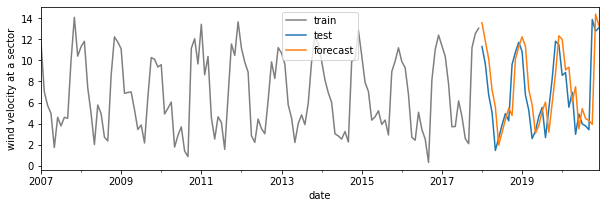

In [230]:
plot_forecast(train_plot_dc[(21.5, 116.5)], test_plot_dc[(21.5, 116.5)], forecast_dc[(21.5, 116.5)], feature, "ema_1")

The RMSE is 4.5560
The MAE is 3.9155
The R2 score is -0.6766


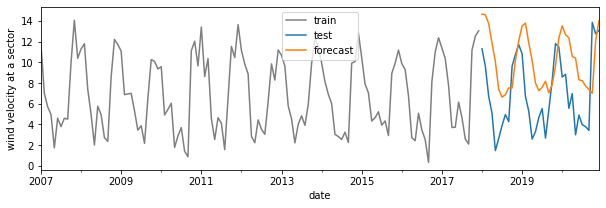

In [231]:
plot_forecast(train_plot_dc[(21.5, 116.5)], test_plot_dc[(21.5, 116.5)], forecast_dc[(21.5, 116.5)], feature, "ema_5")

The RMSE is 3.9078
The MAE is 3.2710
The R2 score is -0.2334


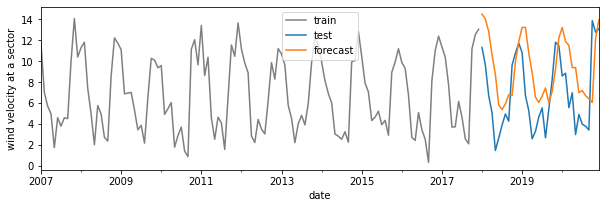

In [232]:
plot_forecast(train_plot_dc[(21.5, 116.5)], test_plot_dc[(21.5, 116.5)], forecast_dc[(21.5, 116.5)], feature, "ema_6")

The RMSE is 3.4180
The MAE is 2.7142
The R2 score is 0.0563


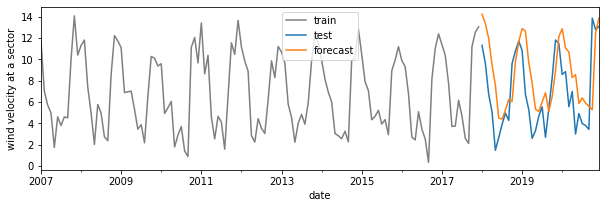

In [266]:
plot_forecast(train_plot_dc[(21.5, 116.5)], test_plot_dc[(21.5, 116.5)], forecast_dc[(21.5, 116.5)], feature, "ema_7")

The RMSE is 2.5716
The MAE is 2.2424
The R2 score is 0.4658


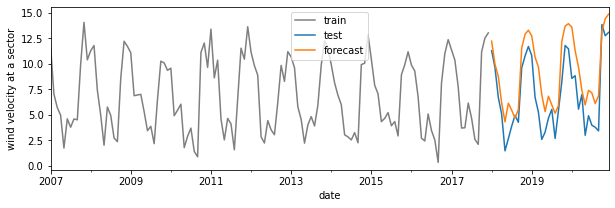

In [265]:
plot_forecast(train_plot_dc[(21.5, 116.5)], test_plot_dc[(21.5, 116.5)], forecast_dc[(21.5, 116.5)], feature, "prophet")

The RMSE is 1.3291
The MAE is 1.0620
The R2 score is 0.8573


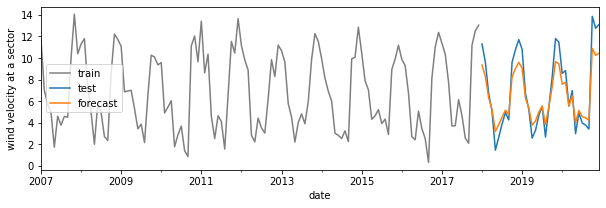

In [263]:
plot_forecast(train_plot_dc[(21.5, 116.5)], test_plot_dc[(21.5, 116.5)], forecast_dc[(21.5, 116.5)], feature, "lstm_relu")

The RMSE is 1.3804
The MAE is 1.2143
The R2 score is 0.8461


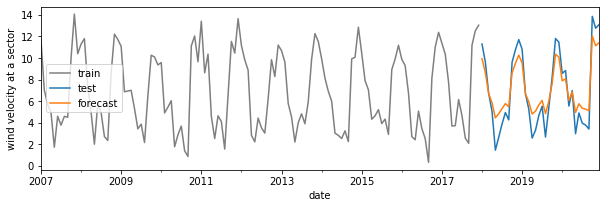

In [264]:
plot_forecast(train_plot_dc[(21.5, 116.5)], test_plot_dc[(21.5, 116.5)], forecast_dc[(21.5, 116.5)], feature, "lstm_tanh")